In [1]:
# Import Moudles and Packages
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

In [2]:
import torch
import torch.nn as nn
from torch.utils import data as D

from pytorch_toolbelt import losses
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

In [3]:
torch.cuda.is_available()

True

In [4]:
from src import config as C
from src.models import hrnet, resnet
from src.dataset import kface_dataset as K
from src.dataset import kface_transform as T
from src.utils.collate_fn import *
from src.utils.print_overwrite import *

In [5]:
print(f"| Number of image : {len(C.IMAGE_LIST)}")
print(f"| Number of label : {len(C.LABEL_LIST)}")

| Number of image : 100
| Number of label : 100


In [6]:
print(f"| Number of train : {C.LEN_TRAIN_SET}")
print(f"| Number of valid : {C.LEN_VALID_SET}")

| Number of train : 90
| Number of valid : 10


In [7]:
dataset = K.kfacedataset(image_list=C.IMAGE_LIST, label_list=C.LABEL_LIST, transform=T.Transforms())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


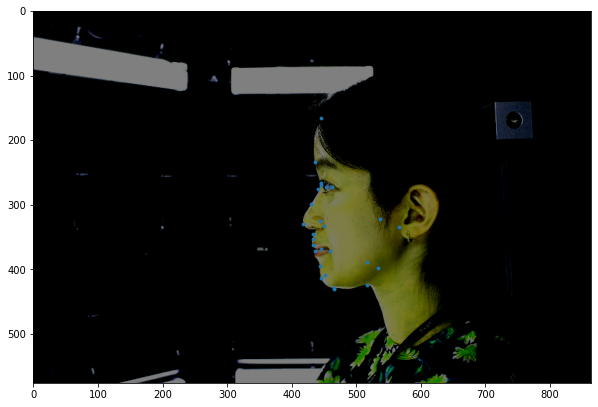

In [8]:
image, landmarks = dataset[0]
plt.figure(figsize=(10, 10))
plt.imshow(image.permute(1,2,0), cmap='gray');
plt.scatter(landmarks.T[0], landmarks.T[1], s=8);

In [9]:
train_dataset, valid_dataset = D.random_split(dataset, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(train_dataset, batch_size=C.BATCH_SIZE["TRAIN"], shuffle=True, num_workers=C.WORKERS)
valid_loader = D.DataLoader(valid_dataset, batch_size=C.BATCH_SIZE["VALID"], shuffle=True, num_workers=C.WORKERS)

train_images, train_landmarks = next(iter(train_loader))
valid_images, valid_landmarks = next(iter(valid_loader))

print(f"| Size of image in train_loader : {train_images.shape}")
print(f"| Size of label in train_loader : {train_landmarks.shape}")
print(f"| Size of image in train_loader : {valid_images.shape}")
print(f"| Size of label in train_loader : {valid_landmarks.shape}")

| Size of image in train_loader : torch.Size([32, 3, 576, 864])
| Size of label in train_loader : torch.Size([32, 27, 2])
| Size of image in train_loader : torch.Size([2, 3, 576, 864])
| Size of label in train_loader : torch.Size([2, 27, 2])


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
model = resnet.Network()

In [12]:
# model_dict = model.state_dict()
# pretrained_dict = torch.load(C.PRETRAINED_ROOT)
# # for layer in pretrained_dict:
# #     print(layer, '\t', pretrained_dict[layer].size())
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# model_dict.update(pretrained_dict)
# model.load_state_dict(pretrained_dict, strict=False)

In [14]:
x = torch.randn([1, 1, 567, 864])
out = model(x).to(device)
print(f"input : {x.shape} | output : {out.size()}")

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.EPOCHS, T_mult=1)

In [ ]:
import torch.nn as nn
import time

criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)

loss_min = np.inf

torch.cuda.empty_cache()

start_time = time.time()
for epoch in range(1,C.EPOCHS+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    model.train()
    for step in range(1,len(train_loader)+1):
        model = model.to(device)    
        images, landmarks = next(iter(train_loader))
        
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        

        predictions = model(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    model.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.to(C.DEVICE)
            landmarks = landmarks.view(landmarks.size(0),-1).to(C.DEVICE)
        
            predictions = model(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

In [ ]:
landmarks.view(landmarks.size(0),-1)
landmarks.shape